1. Install Dependencies and Setup 

In [1]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.17.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.4.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.66.1-cp312-cp312-macosx_10_9_universal2.whl.metadata (3.9 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-

In [2]:
!pip install Pillow

In [3]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                           0.1.3
appscript                         1.1.2
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow              

In [4]:
import tensorflow as tf
import os

2. Remove Dodgy Images

In [5]:
import cv2
from PIL import Image

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    image_class_path = os.path.join(data_dir, image_class)

    if os.path.isdir(image_class_path):
        for image in os.listdir(image_class_path):
            image_path = os.path.join(image_class_path, image)
            try:
                with Image.open(image_path) as img:
                    image_format = img.format.lower()
                    
                    if image_format not in image_exts:
                        print('Image not in ext list {}'.format(image_path))
                        os.remove(image_path)
            except Exception as e:
                print('Issue with image {}: {}'.format(image_path, e))
                # os.remove(image_path)
    else:
        print('Skipping non-directory item {}'.format(image_class_path))
        # os.remove(image_class_path)

Skipping non-directory item data/.DS_Store


3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory(
    'data', 
    label_mode='int', 
    image_size=(256, 256), 
    batch_size=32
)

Found 101000 files belonging to 101 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

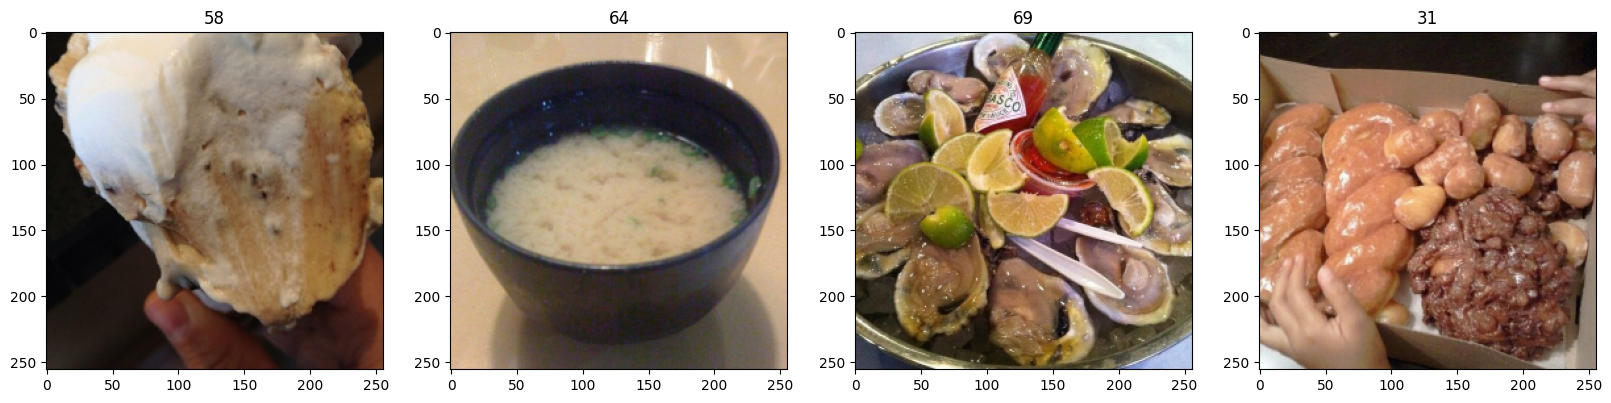

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

5. Split Data

In [16]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [17]:
train_size

2209

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(101, activation='softmax')) 

/Users/atwins/Documents/GitHub/image-classification/imageclassification/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,409,541 (28.27 MB)

 Trainable params: 7,409,541 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1119s 506ms/step - accuracy: 0.0151 - loss: 4.5924 - val_accuracy: 0.0457 - val_loss: 4.3496
Epoch 2/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1298s 587ms/step - accuracy: 0.0453 - loss: 4.3480 - val_accuracy: 0.0944 - val_loss: 4.0536
Epoch 3/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1237s 560ms/step - accuracy: 0.0814 - loss: 4.0979 - val_accuracy: 0.1181 - val_loss: 3.8978
Epoch 4/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1671s 756ms/step - accuracy: 0.1108 - loss: 3.8782 - val_accuracy: 0.1305 - val_loss: 3.8213
Epoch 5/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1692s 766ms/step - accuracy: 0.1419 - loss: 3.6555 - val_accuracy: 0.1278 - val_loss: 3.8075
Epoch 6/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1891s 856ms/step - accuracy: 0.1781 - loss: 3.4175 - val_accuracy: 0.1299 - val_loss: 3.8469
Epoch 7/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1937s 876ms/step - accuracy: 0.2214 - loss: 3.1600 - val_accuracy: 0.1232 - val_loss: 3.9376
Epoch 8/20
2209/2209 ━━━━━━━━━━━━━━━━━━━━ 1262s 571ms/s

8. Plot Performance

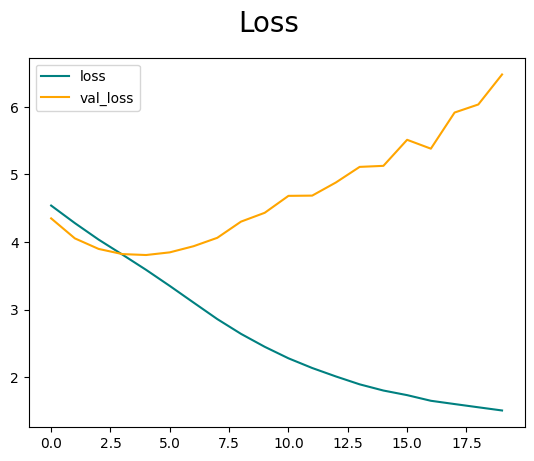

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

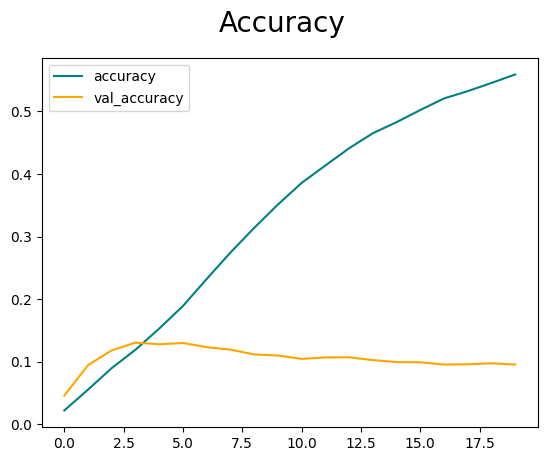

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=1)
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-09-01 23:20:26.445797: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.9894915819168091
Recall: 0.9913766980171204
Accuracy: 0.010119047947227955


10. Test

In [35]:
import cv2

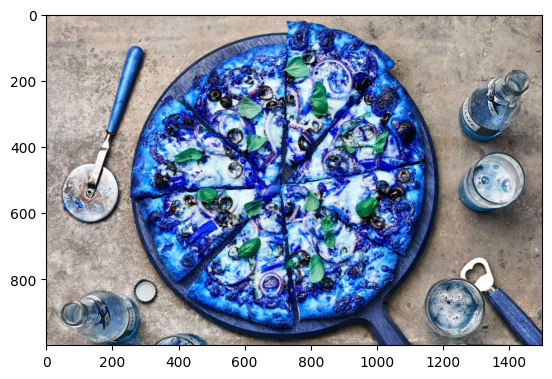

In [86]:
img = cv2.imread('foodtest.jpg')
plt.imshow(img)
plt.show()

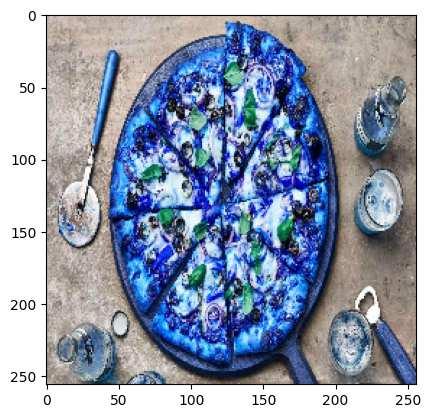

In [87]:
img_resized = tf.image.resize(img, (256, 256))
img_resized = img_resized / 255.0 
plt.imshow(img_resized)
plt.show()

In [88]:
yhat = model.predict(np.expand_dims(img_resized, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [89]:
yhat_class = np.argmax(yhat, axis=1)[0]

In [90]:
print(f'Predicted class is {yhat_class}')

Predicted class is 29


11. Save the Model

In [91]:
from tensorflow.keras.models import load_model

In [92]:
model_path = os.path.join('models', 'imageclassifier.keras')

In [93]:
new_model = load_model(model_path)

In [67]:
new_model.predict(np.expand_dims(img_resized, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


array([[0.989697]], dtype=float32)